<img src = "https://github.com/VeryFatBoy/notebooks/blob/main/common/images/img_github_singlestore-jupyter_featured_2.png?raw=true">

<div id="singlestore-header" style="display: flex; background-color: rgba(235, 249, 245, 0.25); padding: 5px;">
    <div id="icon-image" style="width: 90px; height: 90px;">
        <img width="100%" height="100%" src="https://raw.githubusercontent.com/singlestore-labs/spaces-notebooks/master/common/images/header-icons/browser.png" />
    </div>
    <div id="text" style="padding: 5px; margin-left: 10px;">
        <div id="badge" style="display: inline-block; background-color: rgba(0, 0, 0, 0.15); border-radius: 4px; padding: 4px 8px; align-items: center; margin-top: 6px; margin-bottom: -2px; font-size: 80%">SingleStore Notebooks</div>
        <h1 style="font-weight: 500; margin: 8px 0 0 4px;">Using Uber's H3 to visualise British Transport Police crime data</h1>
    </div>
</div>

In [1]:
!pip install geopandas h3 pandas --quiet --no-warn-script-location

In [2]:
import geopandas as gpd
import pandas as pd

from h3 import h3
from shapely.geometry import Polygon

In [3]:
df = pd.read_csv("2024-08-btp-street.csv")

crimes = gpd.GeoDataFrame(
    df["Crime type"],
    geometry = gpd.points_from_xy(df.Longitude, df.Latitude),
    crs = "EPSG:4326"
)

crimes.head(5)

,Crime type,geometry
0,Bicycle theft,POINT (-0.32764 50.83438)
1,Vehicle crime,POINT (-0.32764 50.83438)
2,Other theft,POINT (-0.23643 50.83255)
3,Violence and sexual offences,POINT (-0.23643 50.83255)
4,Other theft,POINT (-3.55862 54.64503)


In [4]:
h3_level = 5

# https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/

def lat_lng_to_h3(row):
    return h3.geo_to_h3(
        row.geometry.y, row.geometry.x, h3_level
    )

crimes["h3"] = crimes.apply(lat_lng_to_h3, axis = 1)

crimes.head(5)

,Crime type,geometry,h3
0,Bicycle theft,POINT (-0.32764 50.83438),85194a73fffffff
1,Vehicle crime,POINT (-0.32764 50.83438),85194a73fffffff
2,Other theft,POINT (-0.23643 50.83255),85194a73fffffff
3,Violence and sexual offences,POINT (-0.23643 50.83255),85194a73fffffff
4,Other theft,POINT (-3.55862 54.64503),85195097fffffff


In [5]:
# https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/

counts = (crimes.groupby(["h3"])
                .h3.agg("count")
                .to_frame("count")
                .reset_index()
)

counts.head(5)

,h3,count
0,851870d3fffffff,1
1,851870dbfffffff,1
2,85187433fffffff,1
3,85187463fffffff,1
4,8518746bfffffff,1


In [6]:
# https://spatialthoughts.com/2020/07/01/point-in-polygon-h3-geopandas/

def add_geometry(row):
    points = h3.h3_to_geo_boundary(
        row["h3"], True
    )
    return Polygon(points)

counts["geometry"] = counts.apply(add_geometry, axis = 1)

counts.head(5)

,h3,count,geometry
0,851870d3fffffff,1,POLYGON ((-5.3895450275705175 50.2383686006280...
1,851870dbfffffff,1,POLYGON ((-5.618770916484385 50.21578200467119...
2,85187433fffffff,1,POLYGON ((-4.402362230572691 50.46432248133249...
3,85187463fffffff,1,POLYGON ((-5.0895660767735675 50.4018208682358...
4,8518746bfffffff,1,POLYGON ((-5.319050950902007 50.38000939979234...


In [7]:
crimes_h3 = gpd.GeoDataFrame(counts, crs = "EPSG:4326")

crimes_h3.head(5)

,h3,count,geometry
0,851870d3fffffff,1,"POLYGON ((-5.38955 50.23837, -5.48931 50.18359..."
1,851870dbfffffff,1,"POLYGON ((-5.61877 50.21578, -5.71845 50.16074..."
2,85187433fffffff,1,"POLYGON ((-4.40236 50.46432, -4.5027 50.41076,..."
3,85187463fffffff,1,"POLYGON ((-5.08957 50.40182, -5.18967 50.34749..."
4,8518746bfffffff,1,"POLYGON ((-5.31905 50.38001, -5.41907 50.32542..."


[]

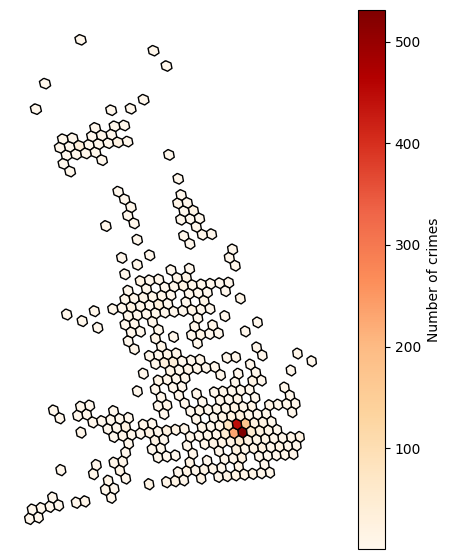

In [8]:
btp_crimes = crimes_h3.plot(
    column = "count",
    cmap = "OrRd",
    edgecolor = "black",
    figsize = (7, 7),
    legend = True,
    legend_kwds = {
        "label" : "Number of crimes",
        "orientation" : "vertical"
    }
)

btp_crimes.set_axis_off()

btp_crimes.plot()